# Table of Contents
 <p><div class="lev1"><a href="#Task-1.-Compiling-Ebola-Data"><span class="toc-item-num">Task 1.&nbsp;&nbsp;</span>Compiling Ebola Data</a></div>
 <div class="lev1"><a href="#Task-2.-RNA-Sequences"><span class="toc-item-num">Task 2.&nbsp;&nbsp;</span>RNA Sequences</a></div>
 <div class="lev1"><a href="#Task-3.-Class-War-in-Titanic"><span class="toc-item-num">Task 3.&nbsp;&nbsp;</span>Class War in Titanic</a></div></p>

In [2]:
DATA_FOLDER = 'Data/' # Use the data folder provided in Tutorial 02 - Intro to Pandas.

## Task 1. Compiling Ebola Data

The `DATA_FOLDER/ebola` folder contains summarized reports of Ebola cases from three countries (Guinea, Liberia and Sierra Leone) during the recent outbreak of the disease in West Africa. For each country, there are daily reports that contain various information about the outbreak in several cities in each country.

Use pandas to import these data files into a single `Dataframe`.
Using this `DataFrame`, calculate for *each country*, the *daily average* per month of *new cases* and *deaths*.
Make sure you handle all the different expressions for *new cases* and *deaths* that are used in the reports.

Import usefull libraries.

In [3]:
import pandas as pd
import numpy as np
from os import listdir
from os.path import isfile, join
from datetime import datetime


After having take a look carefully to the data we notice that in the 3 datasets there is not a report for each day, we also notice that each file contains cumulative value of the new cases/deaths. We will thus extrapolate the average new per day in one month with these cumulative values, indeed if we know the total number $x_d$ of deaths at day d and the total number of death $x_{d + n}$ at day d + n we know that there was in average $\frac{x_{d + n} - x_d}{n}$ new deaths per day during this period. Thus by evaluating the number of death at the first day of the month and the total number of deaths at the end of the month, to evaluate this two quantities we will use a linear regression between the two report closest to the begin of the month and the same for the end of the month.

So first let's import the data into one data frame. We will then hot one encode the different categories of value observed. After that we will aggregate the data on country and day. We will finally drop the column not concerned by cumulative values for deaths and new cases. After that we will check that each row of the data as a non null value for the two cumulative values. If that is ok it would mean that we have not missed any categories of interest. We will finally plot the data to search after unconsistent value. Finally we will apply the developpment explain above to compute the average value for each month.

Load the data in one dataframe. During this phase we reorganise the data and remove sample having unknown or 0 value for the observed data, indeed zero value won't have any influence on our value of interest which is an average value.

In [ ]:
folders = ['guinea', 'liberia', 'sl']
folder_end = '_data/'
folder_begin = 'ebola/'

type_of_file = []
name_of_file = []

ebola_data = pd.DataFrame(columns=['country', 'town', 'date', 'description', 'number'])
for folder in folders:
    folder_path = DATA_FOLDER + folder_begin + folder + folder_end
    print("Loading data from %s" % folder)
    for data_file in listdir(folder_path):
        if isfile(join(folder_path, data_file)):
            metas = data_file.replace('.', '-').split('-')
            meta_date = datetime(int(metas[0]), int(metas[1]), int(metas[2]))
            datas = pd.DataFrame.from_csv(folder_path + data_file)
            towns = datas.columns[2:]
            date = datas.index.name
            description = datas.columns[0]
            if not(list(datas.columns) in type_of_file):
                type_of_file.append(list(datas.columns))
                name_of_file.append(join(folder_path, data_file))
            for town in towns:
                town_data = datas[datas[town] != 0].reset_index().copy()
                town_data['country'] = folder
                town_data['town'] = town
                town_data = town_data[['country', 'town', date, description, town]]
                town_data.columns = ['country', 'town', 'date', 'description', 'number']
                town_data = town_data[(town_data.number.isnull() == False) & (town_data.number != 0)]
                ebola_data = pd.concat([ebola_data, town_data], axis=0)
  
print(len(type_of_file))
print(type_of_file)
ebola_data_hot_encoded = pd.get_dummies(ebola_data, columns=['description'])
for description in ebola_data_hot_encoded.columns[4:]:
    ebola_data_hot_encoded.loc[(ebola_data_hot_encoded[description] == 1), description] = ebola_data_hot_encoded[ebola_data_hot_encoded[description] == 1].number


In [114]:
folders = ['guinea', 'liberia', 'sl']
folder_end = '_data/'
folder_begin = 'ebola/'

type_of_file = []
name_of_file = []
counter = 0
ebola_data = pd.DataFrame(columns=['country', 'date', 'description', 'number'])
for folder in folders:
    folder_path = DATA_FOLDER + folder_begin + folder + folder_end
    print("Loading data from %s" % folder)
    for data_file in listdir(folder_path):
        counter = counter + 1
        if isfile(join(folder_path, data_file)):
            metas = data_file.replace('.', '-').split('-')
            meta_date = datetime.datetime(int(metas[0]), int(metas[1]), int(metas[2]))
            datas = pd.DataFrame.from_csv(folder_path + data_file)
            datas.columns = [col.lower() for col in datas.columns]
            towns = list(datas.columns[1:])
            date = datas.index.name
            description = datas.columns[0]
            if not(list(datas.columns) in type_of_file):
                type_of_file.append(list(datas.columns))
                name_of_file.append(join(folder_path, data_file))
            
            total_col_name = 'totals' if 'totals' in datas.columns else 'national'
            towns.remove(total_col_name)
            datas.fillna(0)
            datas = datas.reset_index().copy()
            datas['country'] = folder
            datas = datas[~datas[total_col_name].astype(str).str.contains('%')]
            old_data = datas.copy()
            datas = datas[['country', date, description, total_col_name]]
            datas.columns = ['country', 'date', 'description', 'number']
            #datas = datas.dropna()
            datas = datas.fillna(0)
            datas = datas[~datas['number'].astype(str).str.contains('%')]
            datas['number'] = datas['number'].astype(str).str.replace(',', '')
            datas['number'] = datas['number'].astype(float).astype(int)
            
            #datas.loc[datas['number'] == 0, 'number'] = np.sum(old_data[datas['number'] == 0][towns], axis=1)

            ebola_data = pd.concat([ebola_data, datas], axis=0)
print(counter)
print(len(type_of_file))
ebola_data_hot_encoded = pd.get_dummies(ebola_data, columns=['description'])
for description in ebola_data_hot_encoded.columns[3:]:
    ebola_data_hot_encoded.loc[(ebola_data_hot_encoded[description] == 1), description] = ebola_data_hot_encoded[ebola_data_hot_encoded[description] == 1].number


Loading data from guinea
Loading data from liberia
Loading data from sl
225
24


Computing the average values for the type of file used by Guinea. Indeed for the Guinea we miss a lot of data we are thus not able to use the daily report to compute the average number of new deaths/cases instead of the daily value we thus use the cumulative value to compute an estimated value of the average number of new deaths/cases per day for each month

In [115]:
ebola_data_hot_encoded = ebola_data_hot_encoded.groupby(by=['country', 'date']).agg(np.max)


In [21]:
import datetime

data_ebola = ebola_data_hot_encoded.copy()
data_guinea = data_ebola.iloc[data_ebola.index.get_level_values('country') == 'guinea']
for col in data_guinea.columns:
    #print(col)
    if 'Cumulative' in col:
        print(col)
data_guinea.reset_index(level=1, inplace=True)
#data_guinea.reset_index()
#print(data_guinea.head())
min_day = 35
min_value = 0
max_day = 0
max_value = 0
month = 8
for val in data_guinea[['date', 'description_Cumulative (confirmed + probable + suspects)']].values:
    date = val[0]
    if month == date.month:
        if min_day > date.day:
            min_day = date.day
            min_value = val[1]
        if max_day < date.day:
            max_day = date.day
            max_value = val[1]
    else:
        print('Average value of new case per day for month %d is %f' % (month, float(max_value - min_value)/float(max_day - min_day)))
        month = date.month
        min_day = date.day
        min_value = val[1]
        max_day = 0
        max_value = 0
#print(data_guinea['description_Total deaths (confirmed + probables + suspects)'])

description_Cumulative (confirmed + probable + suspected)
description_Cumulative (confirmed + probable + suspects)
description_Cumulative CFR
description_Cumulative admission/isolation
description_Cumulative cases among HCW
description_Cumulative confirmed, probable and suspected cases
description_Cumulative deaths among HCW
Average value of new case per day for month 8 is 9.407407
Average value of new case per day for month 9 is 13.535714


Now we're trying to extract only the columns which are relevant to compute the average number of new case and of new death. To do that we search for the words 'new' and 'cases' to conclude that it is related to the number of new cases and to the words 'new' and 'deaths' to conclude that it is related to the number of new deaths. We also keep track of the other column containing the word 'new' which could be relevant to compute new cases. We then look at the different column name which are extracted. 

We see here that there is some ambiguous column which could be problematic. First we should look at a file containing the column 'description_total new cases registered so far' to see what exactly it means, indeed if we use this column we should take care that it is probably a cumulative value. This value could be used to compute the average number per year but if we can drop it out and replace it by daily count of new cases we will do it so that the type of data is more uniform. 

The second interesting column is 'description_new cases of confirmed among health workers' we will also take a loot at a file containing this value in order to see if this value is not already taken into account in another column. 
The same comment maybe done for the columns 'description_newly reported cases in hcw', 'description_newly reported deaths in hcw', 'description_newly reported deaths in hcw'.

The column 'description_new_noncase' should probably also be removed.

Finally in the column containing only the word 'new' we see some which could correspond to new cases: description_new_confirmed
description_new_positive
description_new_probable
description_new_suspected
For each of these column we will then look at a corresponding file to see if the column must be added in the list of new deaths/cases columns.


In the data we also notice some percentage value, these are their to tell which percentage of the population has been seen. We assume this value can be neglected for our analysis, indeed as this is a survey on the evolution of Ebola we can suppose that almost all the death and new case of ebola are registered in the file even if the whole population has not been seen.

In [118]:
ebola_data_hot_encoded.columns = [col.lower().replace('\n', '') for col in ebola_data_hot_encoded.columns]

cumulative_deaths = ['description_total death/s in confirmed,  probable, suspected cases',  
                     'description_total death/s in confirmed, probable, suspected cases',
                    'description_total deaths (confirmed + probables + suspects)','cum_death_tmp']

death_to_agg = ['description_death_suspected', 'description_death_probable', 'description_death_confirmed']
ebola_data_hot_encoded['cum_death_tmp'] = np.sum(ebola_data_hot_encoded[death_to_agg].values, axis=1)

cumulative_cases = ['description_cumulative confirmed, probable and suspected cases', 
                    'description_cumulative (confirmed + probable + suspects)', 'cum_cases_tmp1', 'cum_cases_tmp2']

death_to_agg = ['description_total suspected cases', 'description_total probable cases', 'description_total confirmed cases']
ebola_data_hot_encoded['cum_cases_tmp1'] = np.sum(ebola_data_hot_encoded[death_to_agg].values, axis=1)

death_to_agg = ['description_cum_confirmed', 'description_cum_probable', 'description_cum_suspected']
ebola_data_hot_encoded['cum_cases_tmp2'] = np.sum(ebola_data_hot_encoded[death_to_agg].values, axis=1)

ebola_data_hot_encoded.columns = [col.lower().replace('\n', '') for col in ebola_data_hot_encoded.columns]
ebola_data_hot_encoded['cum_cases'] = np.max(ebola_data_hot_encoded[cumulative_cases].values, axis=1)
print(len(ebola_data_hot_encoded[ebola_data_hot_encoded['cum_cases'] == 0]))
print(ebola_data_hot_encoded[ebola_data_hot_encoded['cum_cases'] == 0]['cum_cases'])
ebola_data_hot_encoded['cum_deaths'] = np.max(ebola_data_hot_encoded[cumulative_deaths].values, axis=1)
print(len(ebola_data_hot_encoded[ebola_data_hot_encoded['cum_deaths'] == 0]))
print(ebola_data_hot_encoded[ebola_data_hot_encoded['cum_deaths'] == 0]['cum_deaths'])


6
country  date      
sl       2014-08-26    0
         2014-08-29    0
         2014-09-05    0
         2014-09-12    0
         2014-11-14    0
         2014-11-19    0
Name: cum_cases, dtype: int64
10
country  date      
liberia  2014-09-20    0
         2014-10-11    0
         2014-11-08    0
sl       2014-08-26    0
         2014-08-29    0
         2014-09-05    0
         2014-09-12    0
         2014-11-14    0
         2014-11-19    0
         2014-12-13    0
Name: cum_deaths, dtype: int64


We still have problem in some value for Siera Leon and Liberia however as we only use extreme points to estimate the averages per day we can simply drop these data without any impact on our final result.

In [129]:
ebola_data_hot_encoded = ebola_data_hot_encoded[(ebola_data_hot_encoded['cum_deaths'] != 0) & 
                                                (ebola_data_hot_encoded['cum_cases'] != 0)]

Now we plot the evoluation of the cumulative values over the time in the 3 countries.

guinea


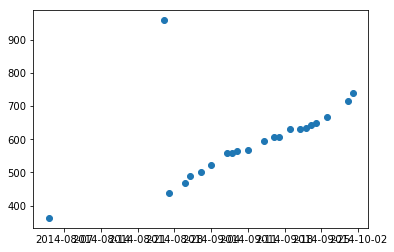

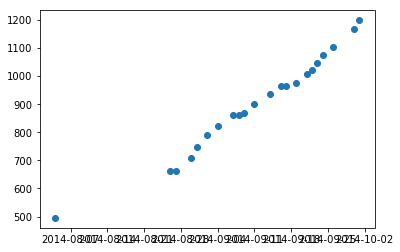

liberia


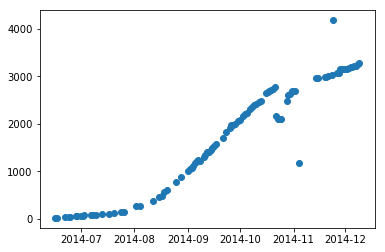

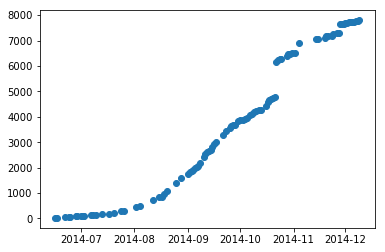

sl


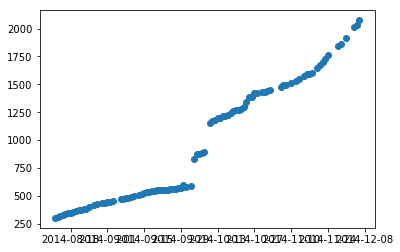

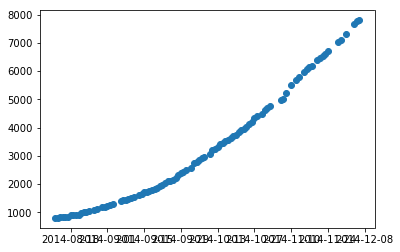

In [130]:
import matplotlib
import matplotlib.pyplot as plt

for folder in folders:
    print(folder)
    data = ebola_data_hot_encoded.iloc[ebola_data_hot_encoded.index.get_level_values('country') == folder]

    dates = matplotlib.dates.date2num(list(data.index.get_level_values('date')))
    plt.plot_date(dates, data['cum_deaths'])
    plt.show()
    plt.plot_date(dates, data['cum_cases'])
    plt.show()


In [22]:
#print(ebola_data.head())
#print(ebola_data_hot_encoded.head())
ebola_data_hot_encoded.columns = [col.lower().replace('\n', '') for col in ebola_data_hot_encoded.columns]
new_cases_col = []
new_deaths_col = []
irrelevant_col = []
relevant_col = []
for col in ebola_data_hot_encoded.columns:
    if ('new' in col) or ('death' in col) or ('case' in col):
        relevant_col.append(col)
        if 'death' in col:
            new_deaths_col.append(col)
        elif 'case' in col:
            new_cases_col.append(col)
    else:
        irrelevant_col.append(col)

print('cases:')
[print('\t%s' % col) for col in new_cases_col]
print('deaths:')
[print('\t%s' % col) for col in new_deaths_col]
print('Relevant:')
[print('\t%s' % col) for col in relevant_col]
print('Other:')
[print('\t%s' % col) for col in irrelevant_col]
''
cumulative_deaths = ['description_total death/s in confirmed,  probable, suspected cases',  
                     'description_total death/s in confirmed,  probable, suspected cases',
                     'description_total death/s in confirmed, probable, suspected cases',
                    'description_total deaths (confirmed + probables + suspects)', 'description_etc_cum_deaths']
cumulative_cases = ['description_cumulative confirmed, probable and suspected cases', 
                    'description_cumulative confirmed, probable and suspected cases',
                    'description_cumulative (confirmed + probable + suspects)', 
                    'description_cumulative (confirmed + probable + suspected)', 'description_total suspected cases', 
                   'description_total probable cases', 'description_total confirmed cases']

cases:
	description_case fatality rate (cfr) -  confirmed & probable cases
	description_case fatality rate (cfr) - confirmed & probable cases
	description_cumulative cases among hcw
	description_cumulative confirmed, probable and suspected cases
	description_new case/s (probable)
	description_new case/s (suspected)
	description_new case/s (confirmed)
	description_new cases of confirmed
	description_new cases of confirmed among health workers
	description_new cases of probables
	description_new cases of suspects
	description_newly reported cases in hcw
	description_number of confirmed cases among health workers
	description_number of female confirmed cases
	description_number of female probables cases
	description_number of female suspects cases
	description_number of male confirmed cases
	description_number of male probables cases
	description_number of male suspects cases
	description_number of probables cases among health workers
	description_number of suspects cases among health wor

Now we look at file containing these numbers.
We notice that the column 'description_total new cases registered so far' is just the sum of the columns new cases of suspects/probables/confirmed but is not a cummulative value over the time. We could thus  use this column instead of the 3 columns new cases of suspects/probables/confirmed.

For the values of  'description_newly reported cases/deaths in hcw' we see that they seem to be always much smaller than the values of new cases/deaths and we suppose thus that we can neglect them wheiter they are already contained in the countage of the new cases/deaths or not. However we will check at the end that it is true that these values can be neglected, if not we won't be able to give a precises answer for the liberia and in a real case we should asked to the dataset creator to lighten the exact meaning of the 'newly reported cases/deaths in hcw' values.

Finally we notice that the columns  'description_new_confirmed', 'description_new_probable',
'description_new_suspected' are significant to count the number of new cases in the Siera Leon files. We also notice that the column '', 'description_new_death', 'description_new_probable',
'description_new_suspected'. During this phase we also noticed that the value of description_etc_new_deaths was very often equal to 0. However as it was given in the FAQ that the other value of death was cummulative thus in a first step we will use this value and not the other one. We will further check that the cummulative value give the same answer.

We then construct our final new_deaths_col and new_cases_col vectors.

In [ ]:
column_to_look_at = ['description_total new cases registered so far', 'description_newly reported cases in hcw', 
                     'description_newly reported deaths in hcw',
                    'description_new_confirmed', 'description_new_positive', 'description_new_probable',
                     'description_new_suspected']
for col in column_to_look_at:
    print(col)
    print(ebola_data_hot_encoded[ebola_data_hot_encoded[col] != 0][ebola_data_hot_encoded.columns[:2]].head())
    
new_cases_col.remove('description_new_noncase')
for col in column_to_look_at[:3]:
    if 'case' in col:
        new_cases_col.remove(col)
    else:
        new_deaths_col.remove(col)
print(new_cases_col)
new_cases_col.extend(['description_new_confirmed', 'description_new_probable', 'description_new_suspected'])

Now we will aggregate the valueof new cases and of new deaths, we will also remove the columns not relevant for deaths and cases.

In [ ]:
ebola_data_hot_encoded = ebola_data_hot_encoded[relevant_col]
t = ebola_data_hot_encoded.copy()
t['test'] = 1
t['new_cases'] = np.sum(t[new_cases_col].values, axis=1)
t['new_deaths'] = np.sum(t[new_deaths_col].values, axis=1)
t = t[['new_cases', 'new_deaths']]
print(t.head())
#print(ebola_data_hot_encoded.head())

Looking at the data obtained.
Peut etre une bonne idée de mettre les descriptions en forme de columns et puis les aggregate. Une bonne idée serait aussi de à la base regarder le nombre de fichier différents on a(différents dans le sens que les colonnes sont différentes et peut etre aussi que les catégories sont diff)

In [ ]:
print(ebola_data_hot_encoded.head())
for country in ebola_data.country.unique():
    country_descriptions = ebola_data[ebola_data.country == country].description.unique()
    towns = ebola_data[ebola_data.country == country].town.unique()
    print('%s: \n%s\n%s' % (country, str(country_descriptions), str(towns)))
    for town in towns:
        town_description_miss = set(country_descriptions) - set(ebola_data[(ebola_data.country == country) 
                                               & (ebola_data.town == town)].description.unique())
        if len(town_description_miss) != 0:
            print('%s: %s\n' % (town, str(town_description_miss)))
            

We can see some weird values which we will inspect. If they appears not trustable and they don't have a too big impact on our value of interest we will then remove them from the dataframe. Weird town are: 'Unnamed: 18' in Liberia and ('Western area urban'
 'Western area rural' 'National' 'Kenema (IFRC)' '34 Military Hospital'
 'Police training School' 'Bo EMC' 'Western area' 'Kenema (KGH)'
 'Hastings-F/Town' 'Western area combined') We thus look at the National value, if its the sum of the 

In [ ]:
# First consider the 'Unnamed: 18' town
print(ebola_data[(ebola_data.country == 'liberia') & (ebola_data.town == 'Unnamed: 18')])

Only one value is not a NaN so this "town" does not seem very trustable. Moreover the only value is probably negligeable over the statistics of the whole country(we will check that). So let's remove this town and evaluate the next weird value.

In [ ]:
print(ebola_data_hot_encoded.columns)
ebola_data_hot_encoded.columns = [col.lower() for col in ebola_data_hot_encoded.columns]

In [ ]:
a = [(('death' in col) & ('new' in col)) for col in ebola_data_hot_encoded.columns]
print(a)
ebola_data_hot_encoded.columns[a]

## Task 2. RNA Sequences

In the `DATA_FOLDER/microbiome` subdirectory, there are 9 spreadsheets of microbiome data that was acquired from high-throughput RNA sequencing procedures, along with a 10<sup>th</sup> file that describes the content of each. 

Use pandas to import the first 9 spreadsheets into a single `DataFrame`.
Then, add the metadata information from the 10<sup>th</sup> spreadsheet as columns in the combined `DataFrame`.
Make sure that the final `DataFrame` has a unique index and all the `NaN` values have been replaced by the tag `unknown`.

In [ ]:
# Write your answer here
datas = pd.DataFrame()

for i in range(1, 10):
    file_name = '%s/microbiome/MID%d.xls' % (DATA_FOLDER, i)
    data = pd.read_excel(open(file_name,'rb'), header=None)
    data.columns = ['Subject', 'Value']
    data['BARCODE'] = 'MID%d' % i
    datas = pd.concat([datas, data], axis=0)

data = pd.read_excel(open('%s/microbiome/metadata.xls' % (DATA_FOLDER),'rb'))
datas = datas.merge(data, how='left', on='BARCODE')
datas = datas.fillna('unknown')
datas.set_index(inplace=True, keys=['Subject', 'BARCODE'])

print(datas.sample(frac=1).head())


## Task 3. Class War in Titanic

Use pandas to import the data file `Data/titanic.xls`. It contains data on all the passengers that travelled on the Titanic.

In [ ]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.core.display import HTML

In [ ]:
HTML(filename=DATA_FOLDER+'/titanic.html')

For each of the following questions state clearly your assumptions and discuss your findings:
1. Describe the *type* and the *value range* of each attribute. Indicate and transform the attributes that can be `Categorical`. 
2. Plot histograms for the *travel class*, *embarkation port*, *sex* and *age* attributes. For the latter one, use *discrete decade intervals*. 
3. Calculate the proportion of passengers by *cabin floor*. Present your results in a *pie chart*.
4. For each *travel class*, calculate the proportion of the passengers that survived. Present your results in *pie charts*.
5. Calculate the proportion of the passengers that survived by *travel class* and *sex*. Present your results in *a single histogram*.
6. Create 2 equally populated *age categories* and calculate survival proportions by *age category*, *travel class* and *sex*. Present your results in a `DataFrame` with unique index.

In [ ]:
dataf = pd.read_excel('Data/titanic.xls')


## Question 1

The current types of each column can easly be obtained using "mb1.dtypes" as shown in next cell.


In [ ]:
dataf_cp = dataf.copy()

print('%-15s %-15s %-35s %-35s' % ('Column Name', 'Column Type', 'Column Min', 'Column Max'))
for col in dataf_cp.columns:
    tmp = dataf_cp[col].dropna()
    if dataf_cp[col].dtypes == 'object':
        tmp = tmp.astype(str)
    print('%-15s %-15s %-35s %-35s' % (col, str(dataf_cp[col].dtypes), str(tmp.min()), str(tmp.max())))


We can change in categorical every columns that has a limited number of distinct value, like: pclass, survived, sex, sibsp, parch, embarked, boat and home.dest.

In [ ]:
to_categorical = ['pclass','survived', 'sex', 'sibsp', 'parch', 'embarked', 'boat', 'home.dest']
for c in to_categorical:
    dataf[c] = dataf[c].astype('category')

## Question 2

In [ ]:
dataf.pclass.value_counts().sort_index().plot(kind='bar')

In [ ]:
dataf.embarked.value_counts().plot(kind='bar')

In [ ]:
dataf.sex.value_counts().plot(kind='bar')

In [ ]:
pd.cut(dataf.age, [x for x in range(0, int(dataf.age.max()) + 1, 10)]).value_counts().sort_index().plot(kind='bar')

## Question 3

As the datas are note clear for the cabin column, we arbitrarily picked the first letter of the first cabin that appears in the cell for the floor. For cabin with cell "C22 D26", we assign the cabin at floor C.

In [ ]:
floor = dataf.cabin.copy().dropna().apply(lambda x : x[0]).astype('category').rename('floor distribution')
data_cabin.value_counts().sort_index().plot(kind='pie', autopct='%1.1f%%', figsize=(10,10))

## Question 4

In [ ]:

fig, axes = plt.subplots(nrows=1, ncols=len(dataf.pclass.unique()))

for cl in dataf.pclass.unique():
    tmp = dataf[dataf.pclass == cl]
    tmp.survived.rename('travel class ' + str(cl) + " - number of passengers : " + str(tmp.shape[0])).value_counts().sort_index().plot(kind='pie', 
                        ax=axes[cl-1], figsize=(18,6), autopct='%1.1f%%', labels=['died', 'survived'])
    

## Question 5

In [ ]:
dataf_res = pd.Series()

tab_survived = ['died', 'survived']

for cl in dataf.pclass.unique():
    for s in dataf.sex.unique():
        tmp = dataf[(dataf.pclass == cl) & (dataf.sex == s)].survived.value_counts().sort_index()
        dataf_res.set_value('travel class: ' + str(cl) + ' - sex: ' + str(s) + ' - ' + tab_survived[tmp.index[0]], tmp.values[0])
        dataf_res.set_value('travel class: ' + str(cl) + ' - sex: ' + str(s) + ' - ' + tab_survived[tmp.index[1]], tmp.values[1])

dataf_res.plot(kind='bar')

## Question 6

In [ ]:
dataf6 = dataf.copy()
dataf6.age=pd.qcut(dataf6.age, 2).dropna()

dataf6.rename(columns={'age':'grouped_age'}, inplace=True)

grouped_index = dataf6.groupby([dataf6.grouped_age, dataf6.pclass, dataf6.sex])
final_data_frame = grouped_index.survived.value_counts().unstack('survived')

final_data_frame.columns = ['dead','survived']
final_data_frame
